***Задание 1. 10 баллов (+2)***

Решите задачу классификации по тональности на подготовленном в одной из семинарских тетрадок корпусе отзывов Google Play, либо на корпусе  IMDB, используя пайплайн с Trainer  от HuggingFace.



1. обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла


2. измените модель, чтобы помимо выхода с пуллер-слоя использовался  эмбеддинг  cls-токена с последнего слоя. -- 3 балла


3. примените к данным готовую модель для классификации последовательности (типа  BertForSequenceClassification) -- 2 балла


*4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса  -- 2 дополнительных балла


5. выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла


Общие требования: (1 балл)

Для всех моделей используйте одинаковые гиперпараметры, чтобы их результаты  можно было сравнить между собой.

Комментируйте ваши решения в коде.  

Для каждой из моделей нужно привести результаты на тестовой выборке.

Вы можете использовать любую предобученную модель, которая подходит для работы с английским, кроме  bert-base-cased

In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.2.2
torch       : 2.5.1+cu121
transformers: 4.47.1



In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 29.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 42.7MB/s]


In [5]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [7]:
df = pd.read_csv('reviews.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [10]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [10]:
class_names = ['negative', 'neutral', 'positive']

<ipython-input-13-c8622670199a>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names);


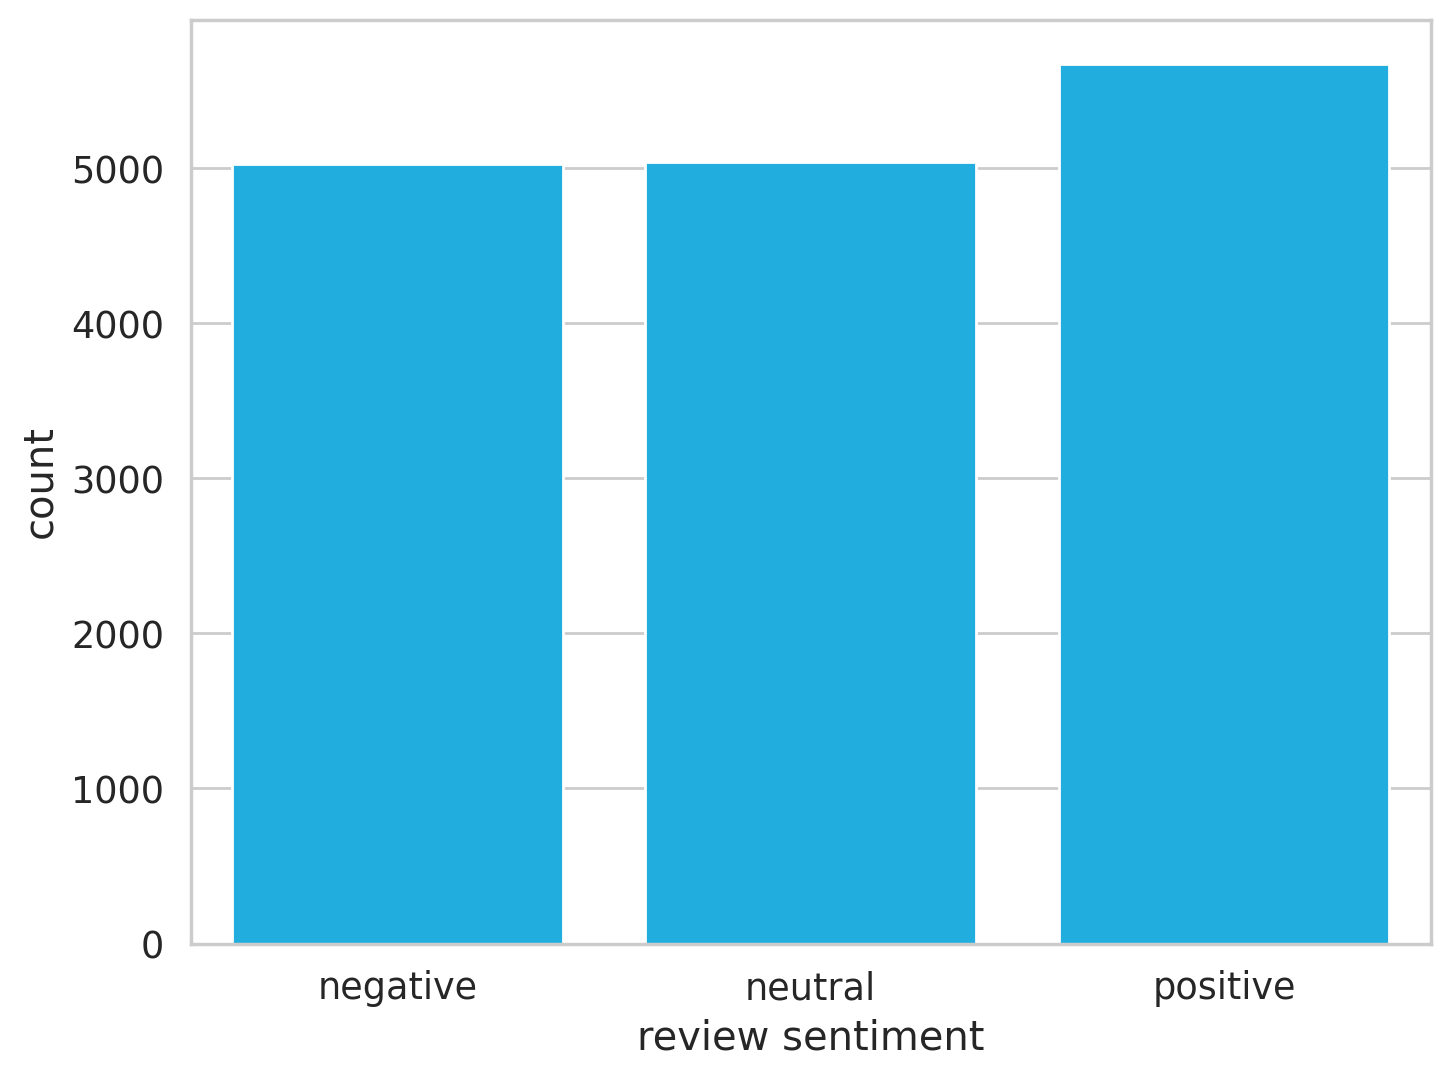

In [13]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'  # выбрала эту

### сначала просто запустила то, что было на семинаре

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [13]:
sample_txt = 'this Text is the text For for TESTING!!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: this Text is the text For for TESTING!!
   Tokens: ['this', 'Text', 'is', 'the', 'text', 'For', 'for', 'T', '##ES', '##TI', '##NG', '!', '!']
Token IDs: [10531, 23701, 10124, 10105, 15541, 11399, 10142, 157, 25054, 72286, 34065, 106, 106]


In [14]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [15]:
MAX_LEN = 160

In [35]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus( # возвращаем энкодинг
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(target, dtype=torch.long)
    }

In [36]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

In [19]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [23]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1 # если windows лучше вроде не указывать больше 1
  )

In [37]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

модель

In [27]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [28]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [29]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # в конфиге скрытый размер

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert( # _ для того, чтобы указать что не нужны эмбеддинги конкретных слов
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [30]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [31]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [32]:
#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False

In [33]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0430, -0.0745, -0.0508,  ...,  0.0054,  0.0206, -0.0270],
        [-0.1651, -0.0817, -0.0393,  ...,  0.0354,  0.0464, -0.0094],
        [ 0.0440, -0.0177, -0.0475,  ...,  0.0024,  0.0828, -0.0004],
        ...,
        [-0.0119,  0.1138,  0.0079,  ...,  0.0154,  0.0414, -0.0708],
        [-0.0701, -0.0275,  0.0516,  ..., -0.0305, -0.0311, -0.0225],
        [-0.0286, -0.0165,  0.0302,  ...,  0.0207,  0.0304,  0.0421]],
       device='cuda:0')

In [34]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [35]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [37]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.8682816225707396 accuracy 0.5750476717948914
Val loss 0.7402377873659134 accuracy 0.6747140884399414

Epoch 2/2
----------
Train loss 0.6950690591241113 accuracy 0.6911298036575317
Val loss 0.6858878266811371 accuracy 0.6886911988258362



In [38]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

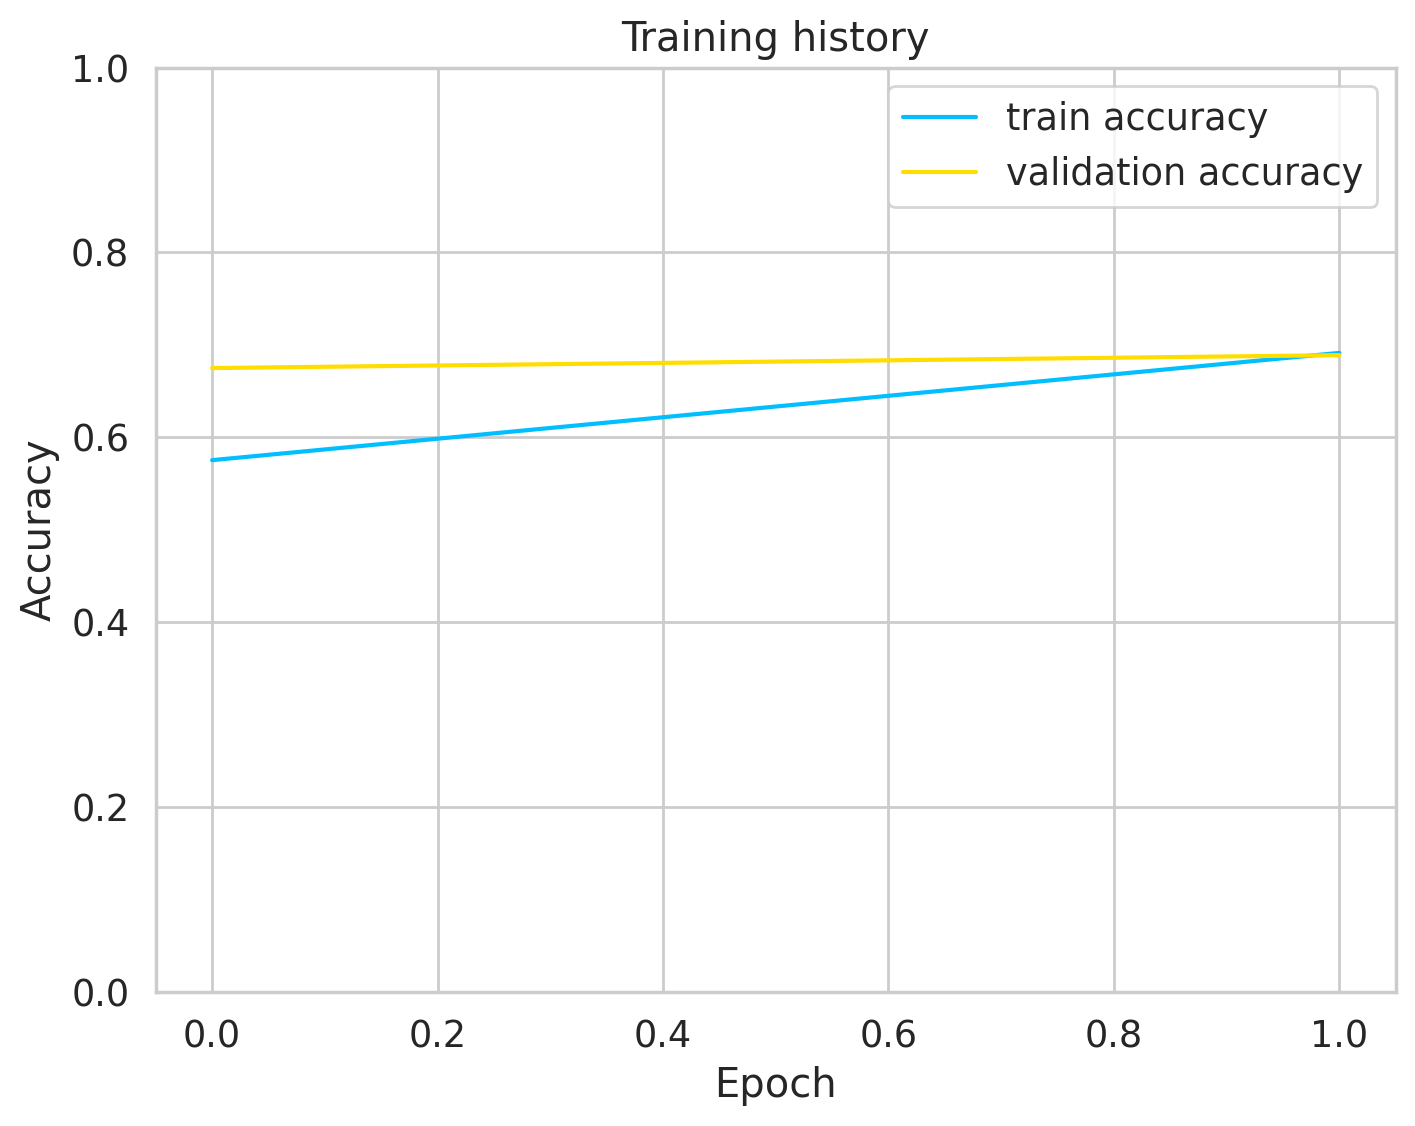

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6776649355888367

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [42]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.68      0.69      0.69       245
     neutral       0.54      0.52      0.53       254
    positive       0.78      0.81      0.80       289

    accuracy                           0.68       788
   macro avg       0.67      0.67      0.67       788
weighted avg       0.67      0.68      0.68       788



### а здесь по пунктам задания

## 3) примените к данным готовую модель для классификации последовательности (типа  BertForSequenceClassification)

In [43]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted') # потому что multiclass
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [44]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification


#тренировочные параметры
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [40]:
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
trainer = Trainer(
    model=model,   # наша модель
    args=training_args,  # параметры
    train_dataset=train_data_loader.dataset,  # датасет для трейна
    eval_dataset=val_data_loader.dataset,  # валидационный датасет
    compute_metrics=compute_metrics,   # метрики
)

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.423300,0.668974,0.747141,0.746548,0.746227,0.747141
2,0.345900,0.519249,0.813215,0.812799,0.813875,0.813215


TrainOutput(global_step=1772, training_loss=0.4876579554839812, metrics={'train_runtime': 915.6091, 'train_samples_per_second': 30.954, 'train_steps_per_second': 1.935, 'total_flos': 2330362651639680.0, 'train_loss': 0.4876579554839812, 'epoch': 2.0})

In [47]:
trainer.evaluate()

{'eval_loss': 0.5192485451698303,
 'eval_accuracy': 0.8132147395171537,
 'eval_f1': 0.8127990249939627,
 'eval_precision': 0.8138751749480614,
 'eval_recall': 0.8132147395171537,
 'eval_runtime': 6.8581,
 'eval_samples_per_second': 114.754,
 'eval_steps_per_second': 7.291,
 'epoch': 2.0}

In [48]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

{'test_loss': 0.48893529176712036,
 'test_accuracy': 0.817258883248731,
 'test_f1': 0.8168580002075791,
 'test_precision': 0.8167519379283926,
 'test_recall': 0.817258883248731,
 'test_runtime': 7.0415,
 'test_samples_per_second': 111.908,
 'test_steps_per_second': 7.101,
 'epoch': 2.0}

 ## 1) обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки)

In [57]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes): # здесь приписываем берту свою голову
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # в конфиге скрытый размер

  def forward(self, input_ids, attention_mask, labels=None):
     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
     pooled_output = outputs[1]
    # classifier head
     logits = self.classifier(pooled_output)

     loss = None
     if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

     return {'loss': loss, 'logits': logits}

In [58]:
model = SentimentClassifier(n_classes=3)

In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics,
)

In [61]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.711300,0.643852,0.725540,0.723618,0.723157,0.725540
2,0.440500,0.522096,0.797967,0.796784,0.796709,0.797967


TrainOutput(global_step=1772, training_loss=0.6043144930700686, metrics={'train_runtime': 967.7038, 'train_samples_per_second': 29.288, 'train_steps_per_second': 1.831, 'total_flos': 0.0, 'train_loss': 0.6043144930700686, 'epoch': 2.0})

In [62]:
trainer.evaluate()

{'eval_loss': 0.5220956802368164,
 'eval_accuracy': 0.7979669631512071,
 'eval_f1': 0.7967844545387514,
 'eval_precision': 0.7967092513917488,
 'eval_recall': 0.7979669631512071,
 'eval_runtime': 7.0717,
 'eval_samples_per_second': 111.288,
 'eval_steps_per_second': 7.07,
 'epoch': 2.0}

In [63]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

{'test_loss': 0.5083199739456177,
 'test_accuracy': 0.8083756345177665,
 'test_f1': 0.8083673643592114,
 'test_precision': 0.8086894246031843,
 'test_recall': 0.8083756345177665,
 'test_runtime': 7.1895,
 'test_samples_per_second': 109.604,
 'test_steps_per_second': 6.955,
 'epoch': 2.0}

## 2) измените модель, чтобы помимо выхода с пуллер-слоя использовался  эмбеддинг  cls-токена с последнего слоя

In [64]:
class SentimentClassifierCLS(nn.Module):

  def __init__(self, n_classes): # здесь приписываем берту свою голову
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size * 2, n_classes) # в конфиге скрытый размер удвоение скрытого размера для конкатенации

  def forward(self, input_ids, attention_mask, labels=None):
     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
     pooled_output = outputs[1]  # аутпут с пуллер слоя

     pooled_output = outputs.pooler_output
     cls_token_emb = outputs.last_hidden_state[:, 0, :] # 1st token in the input sequence = index 0 of the sequence_length dim

     # соединяем их
     combined_output = torch.cat((pooled_output, cls_token_emb), dim=1)

     logits = self.classifier(combined_output)

     loss = None
     if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

     return {'loss': loss, 'logits': logits}

In [65]:
model = SentimentClassifierCLS(n_classes=3)

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics,
)

In [67]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.739000,0.680445,0.698856,0.697015,0.696302,0.698856
2,0.546100,0.563287,0.772554,0.772564,0.772626,0.772554


TrainOutput(global_step=1772, training_loss=0.704362054542548, metrics={'train_runtime': 930.6892, 'train_samples_per_second': 30.453, 'train_steps_per_second': 1.904, 'total_flos': 0.0, 'train_loss': 0.704362054542548, 'epoch': 2.0})

In [68]:
trainer.evaluate()

{'eval_loss': 0.5632873177528381,
 'eval_accuracy': 0.772554002541296,
 'eval_f1': 0.7725643371815182,
 'eval_precision': 0.7726256192567814,
 'eval_recall': 0.772554002541296,
 'eval_runtime': 7.1368,
 'eval_samples_per_second': 110.274,
 'eval_steps_per_second': 7.006,
 'epoch': 2.0}

In [69]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

{'test_loss': 0.5283334851264954,
 'test_accuracy': 0.7855329949238579,
 'test_f1': 0.7844703080025507,
 'test_precision': 0.7837608345091716,
 'test_recall': 0.7855329949238579,
 'test_runtime': 7.216,
 'test_samples_per_second': 109.202,
 'test_steps_per_second': 6.929,
 'epoch': 2.0}

## 4) агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса

In [75]:
class SentimentClassifier4CLS(nn.Module):

  def __init__(self, n_classes): # здесь приписываем берту свою голову
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size * 4, n_classes)

  def forward(self, input_ids, attention_mask, labels=None):
     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True, output_hidden_states=True)
     pooled_output = outputs[1]

     cls_token_emb = [outputs.hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]  # последние 4 слоя
     combined_cls_emb = torch.cat(cls_token_emb, dim=1)  # соединим

     logits = self.classifier(combined_cls_emb)

     loss = None
     if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

     return {'loss': loss, 'logits': logits}

In [76]:
model = SentimentClassifier4CLS(n_classes=3)

In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics,
)

In [78]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.751000,0.672087,0.689962,0.670020,0.681583,0.689962
2,0.505200,0.540239,0.805591,0.804827,0.804542,0.805591


TrainOutput(global_step=1772, training_loss=0.6948536183037554, metrics={'train_runtime': 918.7272, 'train_samples_per_second': 30.849, 'train_steps_per_second': 1.929, 'total_flos': 0.0, 'train_loss': 0.6948536183037554, 'epoch': 2.0})

In [79]:
trainer.evaluate()

{'eval_loss': 0.540239155292511,
 'eval_accuracy': 0.8055908513341804,
 'eval_f1': 0.8048274670052785,
 'eval_precision': 0.8045421786609517,
 'eval_recall': 0.8055908513341804,
 'eval_runtime': 7.1646,
 'eval_samples_per_second': 109.846,
 'eval_steps_per_second': 6.979,
 'epoch': 2.0}

In [80]:
trainer.evaluate(eval_dataset=test_data_loader.dataset, metric_key_prefix="test")

{'test_loss': 0.5164508819580078,
 'test_accuracy': 0.799492385786802,
 'test_f1': 0.7980858775326877,
 'test_precision': 0.7975899096821045,
 'test_recall': 0.799492385786802,
 'test_runtime': 7.0769,
 'test_samples_per_second': 111.348,
 'test_steps_per_second': 7.065,
 'epoch': 2.0}

## 5) выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей

### 0 - негативный, 1 - нейтральный, 2 - позитивный

выбрала 3 отзыва на Genshin Impact с 5, 3 и 1 звёздами

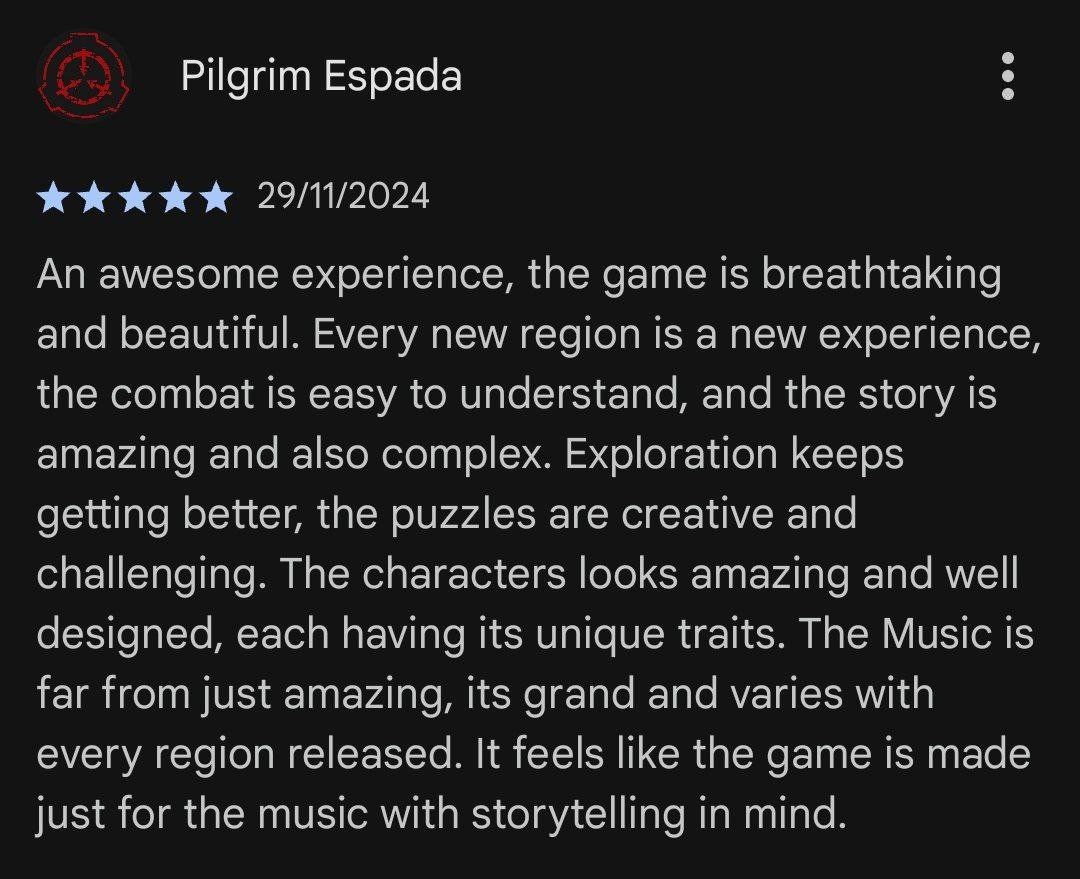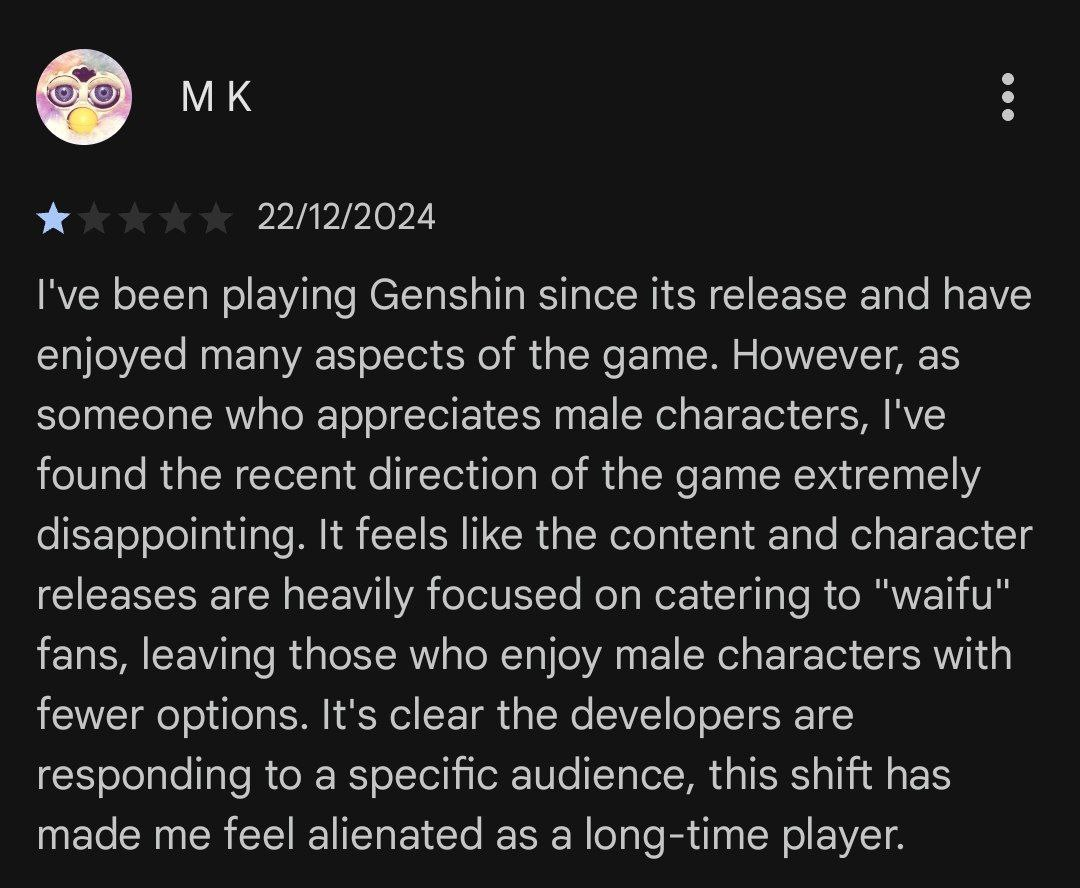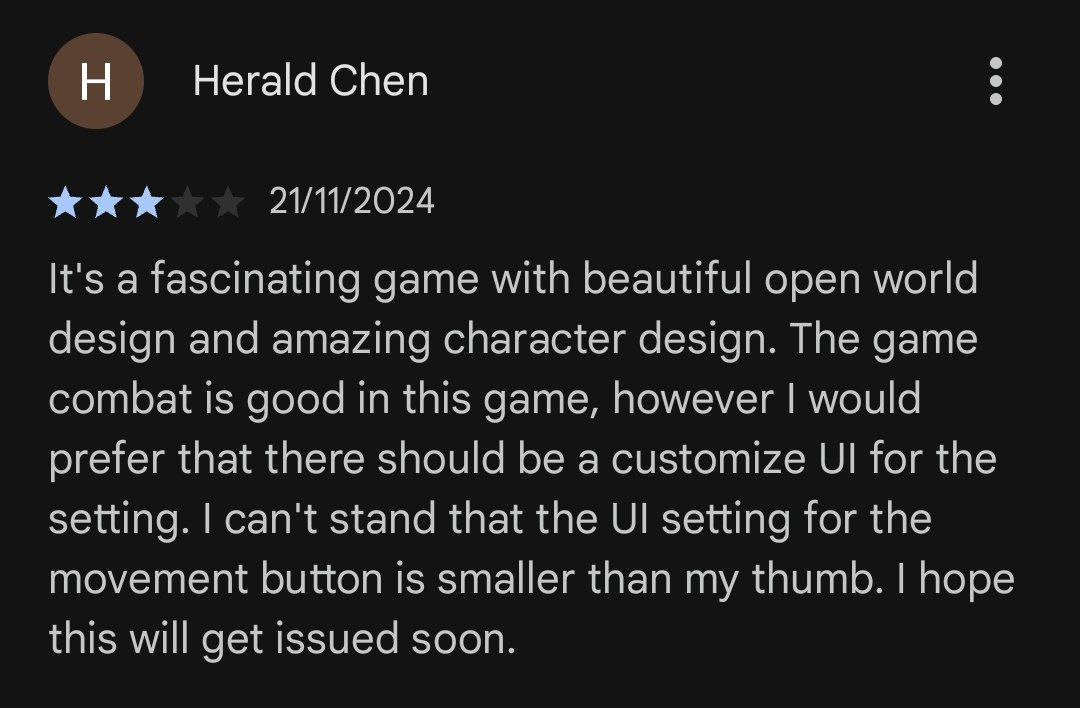

In [82]:
review_5star = 'An awesome experience, the game is breathtaking and beautiful. Every new region is a new experience, the combat is easy to understand, and the story is amazing and also complex. Exploration keeps getting better, the puzzles are creative and challenging. The characters looks amazing and well designed, each having its unique traits. The Music is far from just amazing, its grand and varies with every region released. It feels like the game is made just for the music with storytelling in mind.'
review_3star = "It's a fascinating game with beautiful open world design and amazing character design. The game combat is good in this game, however I would prefer that there should be a customize UI for the setting. I can't stand that the UI setting for the movement button is smaller than my thumb. I hope this will get issued soon."
review_1star = "I've been playing Genshin since its release and have enjoyed many aspects of the game. However, as someone who appreciates male characters, I've found the recent direction of the game extremely disappointing. It feels like the content and character releases are heavily focused on catering to waifu fans, leaving those who enjoy male characters with fewer options. It's clear the developers are responding to a specific audience, this shift has made me feel alienated as a long-time player."

In [95]:
encoded_review1 = tokenizer.encode_plus(
  review_5star,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [96]:
input_ids = encoded_review1['input_ids']
attention_mask = encoded_review1['attention_mask']

In [101]:
class NewReviews(Dataset): # чтобы сделать датасет из 1 отзыва
    def __init__(self, input_ids, attention_mask):
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return 1  # один элемент

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids.squeeze(0),
            'attention_mask': self.attention_mask.squeeze(0),
            'labels': torch.tensor(0) # label for prediction
        }

In [102]:
test_review1 = NewReviews(input_ids, attention_mask)

In [103]:
# предсказание
predictions = trainer.predict(test_review1)
logits = predictions.predictions
# метка класса
preds = logits.argmax(-1)
print(f'Predicted class: {preds.item()}')  # всё правильно, отзыв позитивный

Predicted class: 2


In [104]:
encoded_review2 = tokenizer.encode_plus(
  review_3star,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [105]:
input_ids = encoded_review2['input_ids']
attention_mask = encoded_review2['attention_mask']

In [106]:
test_review2 = NewReviews(input_ids, attention_mask)

In [107]:
predictions = trainer.predict(test_review2)
logits = predictions.predictions
preds = logits.argmax(-1)
print(f'Predicted class: {preds.item()}') # неправильно, отзыв нейтральный, хотя я и сама, если бы не знала, что там 3 звезды, могла бы и 4 предсказать))

Predicted class: 2


In [108]:
encoded_review3 = tokenizer.encode_plus(
  review_1star,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [109]:
input_ids = encoded_review3['input_ids']
attention_mask = encoded_review3['attention_mask']

In [110]:
test_review3 = NewReviews(input_ids, attention_mask)

In [111]:
predictions = trainer.predict(test_review3)
logits = predictions.predictions
preds = logits.argmax(-1)
print(f'Predicted class: {preds.item()}') # неправильно, отзыв негативный

Predicted class: 1


## Итоги

В принципе, результаты не очень сильно отличались, лучшие показатели по f1 были у готовой модели BertForSequenceClassification ('test_f1': 0.8168580002075791).

1) 'test_f1': 0.8083673643592114\
2) 'test_f1': 0.7844703080025507\
3) 'test_f1': 0.8168580002075791\
4) 'test_f1': 0.7980858775326877\
5) Я тестировала отзывы на модели SentimentClassifier4CLS

в основе везде была 'bert-base-multilingual-cased'